# Task for Today  

***

## News Category Prediction  

Given *headlines of news articles*, let's try to predict the **category** of the article.

We will use a TensorFlow/Keras neural network with word embeddings to make our predictions.

# Getting Started

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

import tensorflow as tf

from sklearn.metrics import confusion_matrix, classification_report

In [2]:
data = pd.read_json('data.json', lines=True)

In [3]:
data

,category,headline,authors,link,short_description,date
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26
...,...,...,...,...,...,...
200848,TECH,RIM CEO Thorsten Heins' 'Significant' Plans Fo...,"Reuters, Reuters",https://www.huffingtonpost.com/entry/rim-ceo-t...,Verizon Wireless and AT&T are already promotin...,2012-01-28
200849,SPORTS,Maria Sharapova Stunned By Victoria Azarenka I...,,https://www.huffingtonpost.com/entry/maria-sha...,"Afterward, Azarenka, more effusive with the pr...",2012-01-28
200850,SPORTS,"Giants Over Patriots, Jets Over Colts Among M...",,https://www.huffingtonpost.com/entry/super-bow...,"Leading up to Super Bowl XLVI, the most talked...",2012-01-28
200851,SPORTS,Aldon Smith Arrested: 49ers Linebacker Busted ...,,https://www.huffingtonpost.com/entry/aldon-smi...,CORRECTION: An earlier version of this story i...,2012-01-28


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200853 entries, 0 to 200852
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   category           200853 non-null  object        
 1   headline           200853 non-null  object        
 2   authors            200853 non-null  object        
 3   link               200853 non-null  object        
 4   short_description  200853 non-null  object        
 5   date               200853 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(5)
memory usage: 9.2+ MB


In [5]:
mapping = dict(enumerate(data['category'].unique()))
LABEL_MAPPING = {value: key for key, value in mapping.items()}
LABEL_MAPPING

{'CRIME': 0,
 'ENTERTAINMENT': 1,
 'WORLD NEWS': 2,
 'IMPACT': 3,
 'POLITICS': 4,
 'WEIRD NEWS': 5,
 'BLACK VOICES': 6,
 'WOMEN': 7,
 'COMEDY': 8,
 'QUEER VOICES': 9,
 'SPORTS': 10,
 'BUSINESS': 11,
 'TRAVEL': 12,
 'MEDIA': 13,
 'TECH': 14,
 'RELIGION': 15,
 'SCIENCE': 16,
 'LATINO VOICES': 17,
 'EDUCATION': 18,
 'COLLEGE': 19,
 'PARENTS': 20,
 'ARTS & CULTURE': 21,
 'STYLE': 22,
 'GREEN': 23,
 'TASTE': 24,
 'HEALTHY LIVING': 25,
 'THE WORLDPOST': 26,
 'GOOD NEWS': 27,
 'WORLDPOST': 28,
 'FIFTY': 29,
 'ARTS': 30,
 'WELLNESS': 31,
 'PARENTING': 32,
 'HOME & LIVING': 33,
 'STYLE & BEAUTY': 34,
 'DIVORCE': 35,
 'WEDDINGS': 36,
 'FOOD & DRINK': 37,
 'MONEY': 38,
 'ENVIRONMENT': 39,
 'CULTURE & ARTS': 40}

In [6]:
NUM_CLASSES = len(LABEL_MAPPING)
print("# of classes:", NUM_CLASSES)

# of classes: 41


# Preprocessing

In [7]:
def get_sequences(texts, tokenizer, train=True, max_seq_length=0):
    sequences = tokenizer.texts_to_sequences(texts)
    
    if train == True:
        max_seq_length = np.max(list(map(lambda x: len(x), sequences)))
    
    sequences = pad_sequences(sequences, maxlen=max_seq_length, padding='post')
    
    return sequences

In [8]:
def preprocess_inputs(df, label_mapping=None):
    df = df.copy()
    
    # Use only the headline and category columns
    df = df.loc[:, ['headline', 'category']]
    
    # Sample 1000 examples from each category
    category_samples = []
    
    for category in df['category'].unique():
        category_slice = df.query("category == @category")
        category_samples.append(category_slice.sample(1000, random_state=1))
    df = pd.concat(category_samples, axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)
    
    # Map the labels to integers
    df['category'] = df['category'].replace(label_mapping)
    
    # Split df into X and y
    y = df['category']
    X = df['headline']
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True, random_state=1)
    
    # Fit a tokenizer
    tokenizer = Tokenizer(num_words=10000)
    tokenizer.fit_on_texts(X_train)
    
    # Get sequence data
    X_train = get_sequences(X_train, tokenizer, train=True)
    X_test = get_sequences(X_test, tokenizer, train=False, max_seq_length=X_train.shape[1])
    
    return X_train, X_test, y_train, y_test

In [9]:
X_train, X_test, y_train, y_test = preprocess_inputs(data, label_mapping=LABEL_MAPPING)

In [20]:
X_train.shape

(28699, 26)

In [23]:
X_test.shape

(12301, 26)

In [11]:
y_train

21278    16
34269    34
37854    34
16636    26
34378    30
         ..
7813     28
32511    21
5192     34
12172    13
33003    39
Name: category, Length: 28699, dtype: int64

# Modeling

In [49]:
inputs = tf.keras.Input(shape=(X_train.shape[1],))

embedding = tf.keras.layers.Embedding(
    input_dim=10000,
    output_dim=64
)(inputs)

flatten = tf.keras.layers.Flatten()(embedding)

dense_1 = tf.keras.layers.Dense(64, activation='relu')(flatten)
lstm = L
dense_2 = tf.keras.layers.Dense(64, activation='relu')(dense_1)

outputs = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(dense_1)


model = tf.keras.Model(inputs, outputs)

print(model.summary())
tf.keras.utils.plot_model(model)

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 26)]              0         
_________________________________________________________________
embedding_8 (Embedding)      (None, 26, 64)            640000    
_________________________________________________________________
flatten_8 (Flatten)          (None, 1664)              0         
_________________________________________________________________
dense_24 (Dense)             (None, 64)                106560    
_________________________________________________________________
dense_26 (Dense)             (None, 41)                2665      
Total params: 749,225
Trainable params: 749,225
Non-trainable params: 0
_________________________________________________________________
None
('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.i

# Training

In [63]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    batch_size=32,
    epochs=10,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )
    ]
)

Epoch 1/10
718/718 [==============================] - 6s 8ms/step - loss: 0.0237 - accuracy: 0.9948 - val_loss: 3.7560 - val_accuracy: 0.4389
Epoch 2/10
718/718 [==============================] - 6s 9ms/step - loss: 0.0125 - accuracy: 0.9974 - val_loss: 3.8959 - val_accuracy: 0.4305
Epoch 3/10
718/718 [==============================] - 6s 8ms/step - loss: 0.0102 - accuracy: 0.9974 - val_loss: 4.0624 - val_accuracy: 0.4239
Epoch 4/10
718/718 [==============================] - 6s 8ms/step - loss: 0.0090 - accuracy: 0.9979 - val_loss: 4.2419 - val_accuracy: 0.4206
Epoch 5/10
718/718 [==============================] - 6s 8ms/step - loss: 0.0080 - accuracy: 0.9982 - val_loss: 4.1484 - val_accuracy: 0.4117
Epoch 6/10
718/718 [==============================] - 5s 8ms/step - loss: 0.0075 - accuracy: 0.9980 - val_loss: 4.6019 - val_accuracy: 0.4005
Epoch 7/10
718/718 [==============================] - 5s 8ms/step - loss: 0.0072 - accuracy: 0.9981 - val_loss: 4.3262 - val_accuracy: 0.3946
Epoch 

# Results

In [65]:
print("Test Accuracy: {:.2f}%".format(model.evaluate(X_test, y_test, verbose=0)[1] * 100))

385/385 [==============================] - 0s 1ms/step - loss: 5.0788 - accuracy: 0.3255
Test Accuracy: 32.55%


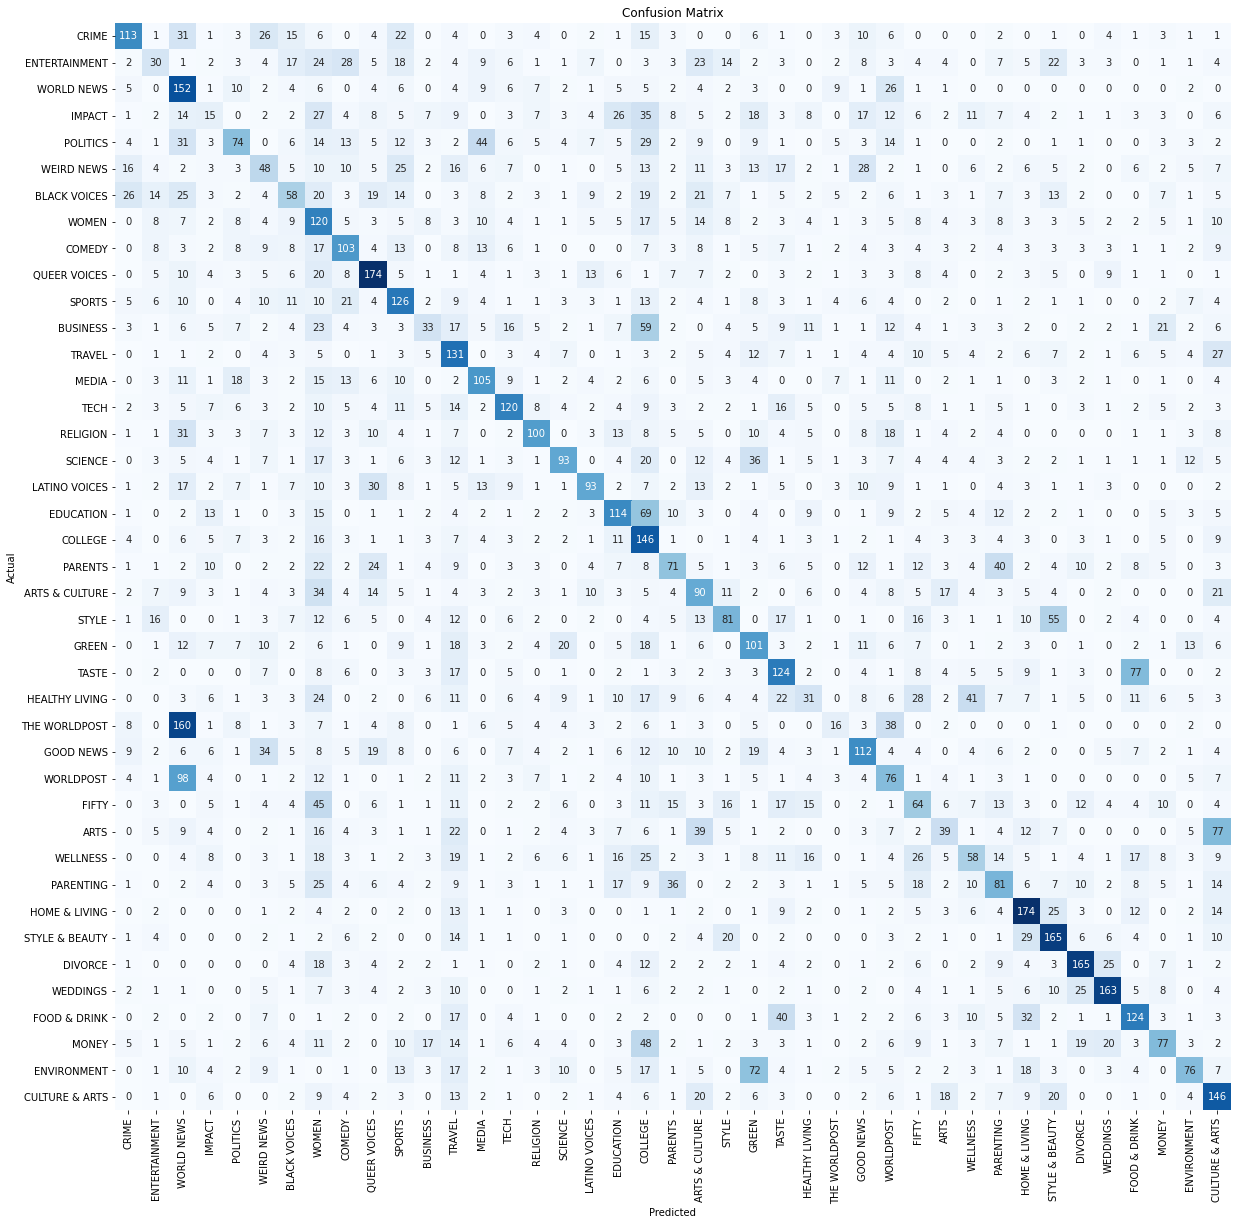

In [15]:
y_pred = np.argmax(model.predict(X_test), axis=1)

cm = confusion_matrix(y_test, y_pred)
clr = classification_report(y_test, y_pred, target_names=list(LABEL_MAPPING.keys()))

plt.figure(figsize=(20, 20))
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
plt.xticks(ticks=np.arange(NUM_CLASSES) + 0.5, labels=list(LABEL_MAPPING.keys()), rotation=90)
plt.yticks(ticks=np.arange(NUM_CLASSES) + 0.5, labels=list(LABEL_MAPPING.keys()), rotation=0)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [16]:
print("Classification Report:\n----------------------\n", clr)

Classification Report:
----------------------
                 precision    recall  f1-score   support

         CRIME       0.52      0.39      0.44       293
 ENTERTAINMENT       0.21      0.11      0.14       279
    WORLD NEWS       0.22      0.54      0.31       280
        IMPACT       0.10      0.05      0.07       293
      POLITICS       0.39      0.23      0.29       324
    WEIRD NEWS       0.19      0.16      0.17       302
  BLACK VOICES       0.26      0.18      0.21       329
         WOMEN       0.17      0.37      0.24       324
        COMEDY       0.36      0.37      0.36       282
  QUEER VOICES       0.45      0.52      0.48       333
        SPORTS       0.34      0.42      0.38       297
      BUSINESS       0.25      0.11      0.15       298
        TRAVEL       0.26      0.45      0.33       293
         MEDIA       0.40      0.41      0.40       259
          TECH       0.44      0.40      0.42       297
      RELIGION       0.48      0.34      0.40       291
